TensorFlow: 2.14.0
Found 700 image-mask pairs.


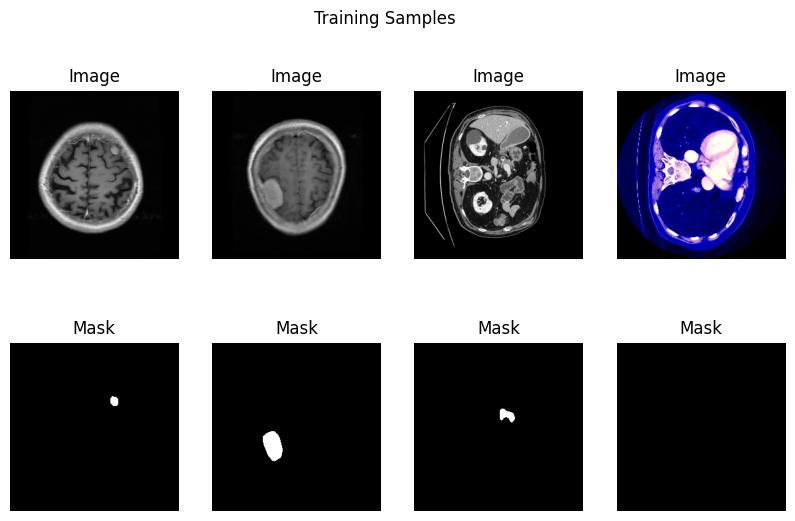

Model: "GM-UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_46 (Conv2D)          (None, 256, 256, 32)         864       ['input_2[0][0]']             
                                                                                                  
 depthwise_conv2d_9 (Depthw  (None, 256, 256, 3)          27        ['input_2[0][0]']             
 iseConv2D)                                                                                       
                                                                                                  
 safe_group_normalization_5  (None, 256, 256, 32)         64        ['conv2d_46[0][0]']     

ValueError: The following argument(s) are not supported with the native Keras format: ['options']

In [2]:
# =========================================
# GM-UNet for MRI Tumor Segmentation
# =========================================

import os, glob, random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow:", tf.__version__)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# ===============================
# 1) Paths & Config
# ===============================
DATASET_DIR = "dataset1"  # <-- change to your dataset root
IMAGES_DIR = os.path.join(DATASET_DIR, "images")
MASKS_DIR  = os.path.join(DATASET_DIR, "masks")

IMG_SIZE = (256, 256)   # image size
BATCH_SIZE = 8
EPOCHS = 25
VAL_SPLIT = 0.2

# ===============================
# 2) Pair images and masks
# ===============================
def list_pairs(images_dir, masks_dir):
    img_paths = sorted(glob.glob(os.path.join(images_dir, "*")))
    pairs = []
    for ip in img_paths:
        fname = os.path.basename(ip)
        mp = os.path.join(masks_dir, fname)
        if os.path.exists(mp):
            pairs.append((ip, mp))
    return pairs

pairs = list_pairs(IMAGES_DIR, MASKS_DIR)
print(f"Found {len(pairs)} image-mask pairs.")

if len(pairs) == 0:
    raise RuntimeError("No image-mask pairs found. Check your paths/filenames.")

train_pairs, val_pairs = train_test_split(pairs, test_size=VAL_SPLIT, random_state=42)

# ===============================
# 3) Data loading & preprocessing
# ===============================
def read_image(path, size=IMG_SIZE):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, size, method="bilinear")
    img = tf.cast(img, tf.float32) / 255.0
    return img

def read_mask(path, size=IMG_SIZE):
    m = tf.io.read_file(path)
    mask = tf.image.decode_image(m, channels=1, expand_animations=False)
    mask = tf.image.resize(mask, size, method="nearest")
    mask = tf.cast(mask, tf.float32) / 255.0
    mask = tf.where(mask > 0.5, 1.0, 0.0)  # binarize
    return mask

def parse_pair(img_path, mask_path):
    return read_image(img_path), read_mask(mask_path)

def augment(img, mask):
    if tf.random.uniform(()) > 0.5:
        img  = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        img  = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)
    return img, mask

AUTOTUNE = tf.data.AUTOTUNE

def make_ds(pairs, training=True):
    img_paths = [p[0] for p in pairs]
    mask_paths = [p[1] for p in pairs]
    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    ds = ds.map(lambda ip, mp: parse_pair(ip, mp), num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
        ds = ds.shuffle(buffer_size=len(pairs))
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_pairs, training=True)
val_ds   = make_ds(val_pairs, training=False)

# ===============================
# 4) Visualize samples
# ===============================
def show_batch(dataset, title="Batch"):
    imgs, masks = next(iter(dataset))
    n = min(4, imgs.shape[0])
    plt.figure(figsize=(10, 6))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(imgs[i])
        plt.title("Image")
        plt.axis("off")
        plt.subplot(2, n, n+i+1)
        plt.imshow(tf.squeeze(masks[i]), cmap="gray")
        plt.title("Mask")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_batch(train_ds, "Training Samples")

# ===============================
# 5) GroupNormalization (Safe)
# ===============================
class SafeGroupNormalization(layers.Layer):
    def __init__(self, groups=8, axis=-1, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.init_groups = groups
        self.axis = axis
        self.epsilon = epsilon

    def build(self, input_shape):
        dim = input_shape[self.axis]
        self.groups = min(self.init_groups, dim)  # ensure groups <= channels
        self.gamma = self.add_weight(name="gamma", shape=(dim,), initializer="ones", trainable=True)
        self.beta  = self.add_weight(name="beta",  shape=(dim,), initializer="zeros", trainable=True)

    def call(self, x):
        input_shape = tf.shape(x)
        N, H, W, C = input_shape[0], input_shape[1], input_shape[2], input_shape[3]
        G = tf.minimum(self.groups, C)
        x = tf.reshape(x, [N, H, W, G, C // G])
        mean, var = tf.nn.moments(x, axes=[1,2,4], keepdims=True)
        x = (x - mean) / tf.sqrt(var + self.epsilon)
        x = tf.reshape(x, [N, H, W, C])
        return self.gamma * x + self.beta

# ===============================
# 6) GM-UNet blocks
# ===============================
def conv_gn_act(x, filters, k=3, s=1, groups=8):
    x = layers.Conv2D(filters, k, strides=s, padding="same", use_bias=False)(x)
    x = SafeGroupNormalization(groups=groups)(x)
    x = layers.Activation("swish")(x)
    return x

def depthwise_pointwise(x, filters, groups_pw=1):
    y = layers.DepthwiseConv2D(3, padding="same", use_bias=False)(x)
    y = SafeGroupNormalization()(y)
    y = layers.Activation("swish")(y)
    try:
        y = layers.Conv2D(filters, 1, padding="same", use_bias=False, groups=groups_pw)(y)
    except TypeError:
        y = layers.Conv2D(filters, 1, padding="same", use_bias=False)(y)
    y = SafeGroupNormalization()(y)
    y = layers.Activation("swish")(y)
    return y

def gm_block(x, filters):
    c1 = conv_gn_act(x, filters)
    c1 = conv_gn_act(c1, filters)
    c2 = depthwise_pointwise(x, filters)
    y = layers.Concatenate()([c1, c2])
    y = layers.Conv2D(filters, 1, padding="same", use_bias=False)(y)
    y = SafeGroupNormalization()(y)
    if x.shape[-1] != filters:
        x = layers.Conv2D(filters, 1, padding="same", use_bias=False)(x)
        x = SafeGroupNormalization()(x)
    y = layers.Add()([x, y])
    y = layers.Activation("swish")(y)
    return y

def encoder_block(x, filters):
    y = gm_block(x, filters)
    p = layers.MaxPooling2D(2)(y)
    return y, p

def decoder_block(x, skip, filters):
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Concatenate()([x, skip])
    x = gm_block(x, filters)
    return x

def build_gmunet(input_shape=(256,256,3), base_filters=32):
    inputs = layers.Input(shape=input_shape)

    s1, p1 = encoder_block(inputs, base_filters)
    s2, p2 = encoder_block(p1, base_filters*2)
    s3, p3 = encoder_block(p2, base_filters*4)
    s4, p4 = encoder_block(p3, base_filters*8)

    b = gm_block(p4, base_filters*16)

    d1 = decoder_block(b, s4, base_filters*8)
    d2 = decoder_block(d1, s3, base_filters*4)
    d3 = decoder_block(d2, s2, base_filters*2)
    d4 = decoder_block(d3, s1, base_filters)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(d4)
    return keras.Model(inputs, outputs, name="GM-UNet")

model = build_gmunet(input_shape=IMG_SIZE + (3,))
model.summary()

# ===============================
# 7) Loss & Metrics
# ===============================
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3])
    dice = (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice)

def iou_coef(y_true, y_pred, smooth=1.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    total = tf.reduce_sum(y_true + y_pred, axis=[1,2,3])
    union = total - intersection
    iou = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou)

def bce_dice_loss(y_true, y_pred):
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_mean(bce) + (1.0 - dice_coef(y_true, y_pred))

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=bce_dice_loss,
    metrics=[dice_coef, iou_coef, "binary_accuracy"]
)

# ===============================
# 8) Train
# ===============================
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "gmunet_best.keras", 
        monitor="val_dice_coef", 
        mode="max", 
        save_best_only=True,
        save_format="keras"
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=6, 
        restore_best_weights=True
    )
]

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

# ===============================
# 9) Plot training history
# ===============================
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss"); plt.legend()
plt.subplot(1,3,2)
plt.plot(history.history["dice_coef"], label="train")
plt.plot(history.history["val_dice_coef"], label="val")
plt.title("Dice"); plt.legend()
plt.subplot(1,3,3)
plt.plot(history.history["iou_coef"], label="train")
plt.plot(history.history["val_iou_coef"], label="val")
plt.title("IoU"); plt.legend()
plt.show()

# ===============================
# 10) Save final model
# ===============================
model.save("gmunet_final.h5")
print("Model saved as gmunet_final.h5")


TensorFlow: 2.14.0
Found 700 image-mask pairs.


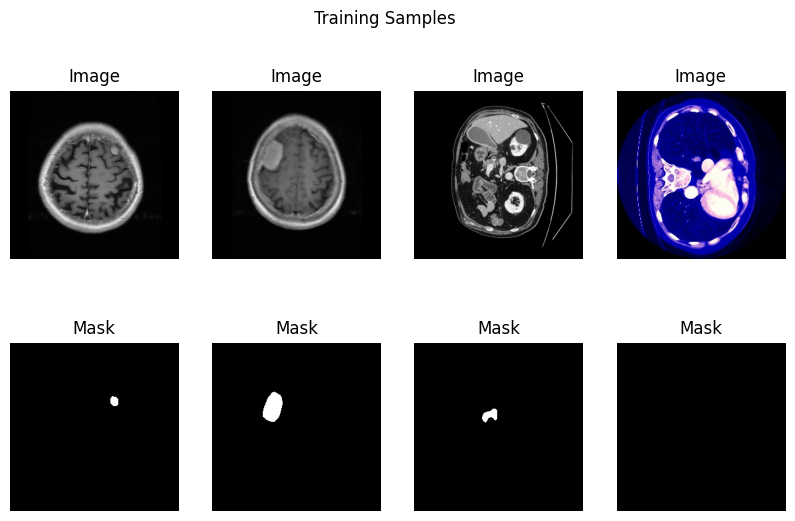

Model: "GM-UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_92 (Conv2D)          (None, 256, 256, 32)         864       ['input_3[0][0]']             
                                                                                                  
 depthwise_conv2d_18 (Depth  (None, 256, 256, 3)          27        ['input_3[0][0]']             
 wiseConv2D)                                                                                      
                                                                                                  
 safe_group_normalization_1  (None, 256, 256, 32)         64        ['conv2d_92[0][0]']     

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


70/70 [==============================] - 1296s 18s/step - loss: 0.9396 - dice_coef: 0.1371 - iou_coef: 0.0907 - binary_accuracy: 0.9783 - val_loss: 0.7777 - val_dice_coef: 0.2665 - val_iou_coef: 0.1932 - val_binary_accuracy: 0.9876
Epoch 2/25
70/70 [==============================] - 1231s 18s/step - loss: 0.7762 - dice_coef: 0.2565 - iou_coef: 0.1906 - binary_accuracy: 0.9913 - val_loss: 0.7154 - val_dice_coef: 0.3113 - val_iou_coef: 0.2339 - val_binary_accuracy: 0.9936
Epoch 3/25
70/70 [==============================] - 1219s 17s/step - loss: 0.6960 - dice_coef: 0.3300 - iou_coef: 0.2603 - binary_accuracy: 0.9940 - val_loss: 0.6450 - val_dice_coef: 0.3835 - val_iou_coef: 0.3074 - val_binary_accuracy: 0.9926
Epoch 4/25
70/70 [==============================] - 1222s 17s/step - loss: 0.5382 - dice_coef: 0.4960 - iou_coef: 0.4303 - binary_accuracy: 0.9939 - val_loss: 0.4554 - val_dice_coef: 0.5752 - val_iou_coef: 0.4985 - val_binary_accuracy: 0.9936
Epoch 5/25
70/70 [=====================

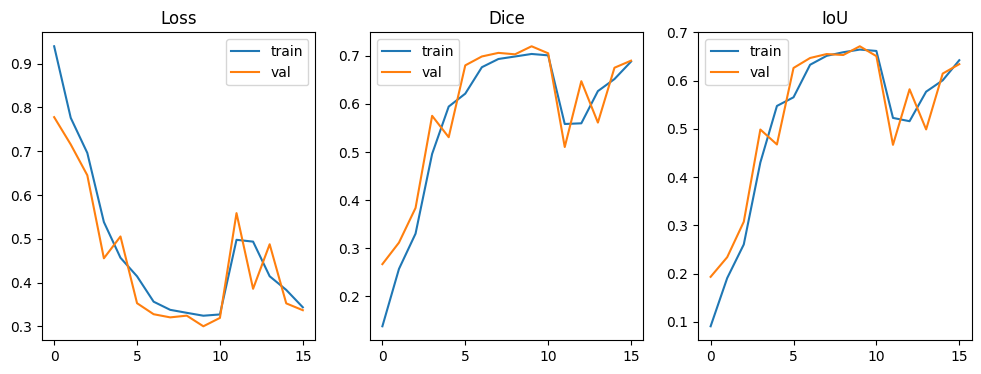

Model saved as gmunet_final.h5


In [3]:
# =========================================
# GM-UNet for MRI Tumor Segmentation
# =========================================

import os, glob, random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow:", tf.__version__)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# ===============================
# 1) Paths & Config
# ===============================
DATASET_DIR = "dataset1"  # <-- change this to your dataset root
IMAGES_DIR = os.path.join(DATASET_DIR, "images")
MASKS_DIR  = os.path.join(DATASET_DIR, "masks")

IMG_SIZE = (256, 256)
BATCH_SIZE = 8
EPOCHS = 25
VAL_SPLIT = 0.2

# ===============================
# 2) Pair images and masks
# ===============================
def list_pairs(images_dir, masks_dir):
    img_paths = sorted(glob.glob(os.path.join(images_dir, "*")))
    pairs = []
    for ip in img_paths:
        fname = os.path.basename(ip)
        mp = os.path.join(masks_dir, fname)
        if os.path.exists(mp):
            pairs.append((ip, mp))
    return pairs

pairs = list_pairs(IMAGES_DIR, MASKS_DIR)
print(f"Found {len(pairs)} image-mask pairs.")

if len(pairs) == 0:
    raise RuntimeError("No image-mask pairs found. Check your paths/filenames.")

train_pairs, val_pairs = train_test_split(pairs, test_size=VAL_SPLIT, random_state=42)

# ===============================
# 3) Data loading & preprocessing
# ===============================
def read_image(path, size=IMG_SIZE):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, size, method="bilinear")
    img = tf.cast(img, tf.float32) / 255.0
    return img

def read_mask(path, size=IMG_SIZE):
    m = tf.io.read_file(path)
    mask = tf.image.decode_image(m, channels=1, expand_animations=False)
    mask = tf.image.resize(mask, size, method="nearest")
    mask = tf.cast(mask, tf.float32) / 255.0
    mask = tf.where(mask > 0.5, 1.0, 0.0)  # binarize
    return mask

def parse_pair(img_path, mask_path):
    return read_image(img_path), read_mask(mask_path)

def augment(img, mask):
    if tf.random.uniform(()) > 0.5:
        img  = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        img  = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)
    return img, mask

AUTOTUNE = tf.data.AUTOTUNE

def make_ds(pairs, training=True):
    img_paths = [p[0] for p in pairs]
    mask_paths = [p[1] for p in pairs]
    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    ds = ds.map(lambda ip, mp: parse_pair(ip, mp), num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
        ds = ds.shuffle(buffer_size=len(pairs))
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_pairs, training=True)
val_ds   = make_ds(val_pairs, training=False)

# ===============================
# 4) Visualize samples
# ===============================
def show_batch(dataset, title="Batch"):
    imgs, masks = next(iter(dataset))
    n = min(4, imgs.shape[0])
    plt.figure(figsize=(10, 6))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(imgs[i])
        plt.title("Image")
        plt.axis("off")
        plt.subplot(2, n, n+i+1)
        plt.imshow(tf.squeeze(masks[i]), cmap="gray")
        plt.title("Mask")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_batch(train_ds, "Training Samples")

# ===============================
# 5) Safe GroupNormalization
# ===============================
class SafeGroupNormalization(layers.Layer):
    def __init__(self, groups=8, axis=-1, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.init_groups = groups
        self.axis = axis
        self.epsilon = epsilon

    def build(self, input_shape):
        dim = input_shape[self.axis]
        self.groups = min(self.init_groups, dim)
        self.gamma = self.add_weight(name="gamma", shape=(dim,), initializer="ones", trainable=True)
        self.beta  = self.add_weight(name="beta",  shape=(dim,), initializer="zeros", trainable=True)

    def call(self, x):
        input_shape = tf.shape(x)
        N, H, W, C = input_shape[0], input_shape[1], input_shape[2], input_shape[3]
        G = tf.minimum(self.groups, C)
        x = tf.reshape(x, [N, H, W, G, C // G])
        mean, var = tf.nn.moments(x, axes=[1,2,4], keepdims=True)
        x = (x - mean) / tf.sqrt(var + self.epsilon)
        x = tf.reshape(x, [N, H, W, C])
        return self.gamma * x + self.beta

# ===============================
# 6) GM-UNet blocks
# ===============================
def conv_gn_act(x, filters, k=3, s=1, groups=8):
    x = layers.Conv2D(filters, k, strides=s, padding="same", use_bias=False)(x)
    x = SafeGroupNormalization(groups=groups)(x)
    x = layers.Activation("swish")(x)
    return x

def depthwise_pointwise(x, filters, groups_pw=1):
    y = layers.DepthwiseConv2D(3, padding="same", use_bias=False)(x)
    y = SafeGroupNormalization()(y)
    y = layers.Activation("swish")(y)
    try:
        y = layers.Conv2D(filters, 1, padding="same", use_bias=False, groups=groups_pw)(y)
    except TypeError:
        y = layers.Conv2D(filters, 1, padding="same", use_bias=False)(y)
    y = SafeGroupNormalization()(y)
    y = layers.Activation("swish")(y)
    return y

def gm_block(x, filters):
    c1 = conv_gn_act(x, filters)
    c1 = conv_gn_act(c1, filters)
    c2 = depthwise_pointwise(x, filters)
    y = layers.Concatenate()([c1, c2])
    y = layers.Conv2D(filters, 1, padding="same", use_bias=False)(y)
    y = SafeGroupNormalization()(y)
    if x.shape[-1] != filters:
        x = layers.Conv2D(filters, 1, padding="same", use_bias=False)(x)
        x = SafeGroupNormalization()(x)
    y = layers.Add()([x, y])
    y = layers.Activation("swish")(y)
    return y

def encoder_block(x, filters):
    y = gm_block(x, filters)
    p = layers.MaxPooling2D(2)(y)
    return y, p

def decoder_block(x, skip, filters):
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Concatenate()([x, skip])
    x = gm_block(x, filters)
    return x

def build_gmunet(input_shape=(256,256,3), base_filters=32):
    inputs = layers.Input(shape=input_shape)

    s1, p1 = encoder_block(inputs, base_filters)
    s2, p2 = encoder_block(p1, base_filters*2)
    s3, p3 = encoder_block(p2, base_filters*4)
    s4, p4 = encoder_block(p3, base_filters*8)

    b = gm_block(p4, base_filters*16)

    d1 = decoder_block(b, s4, base_filters*8)
    d2 = decoder_block(d1, s3, base_filters*4)
    d3 = decoder_block(d2, s2, base_filters*2)
    d4 = decoder_block(d3, s1, base_filters)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(d4)
    return keras.Model(inputs, outputs, name="GM-UNet")

model = build_gmunet(input_shape=IMG_SIZE + (3,))
model.summary()

# ===============================
# 7) Loss & Metrics
# ===============================
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3])
    dice = (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice)

def iou_coef(y_true, y_pred, smooth=1.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    total = tf.reduce_sum(y_true + y_pred, axis=[1,2,3])
    union = total - intersection
    iou = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou)

def bce_dice_loss(y_true, y_pred):
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_mean(bce) + (1.0 - dice_coef(y_true, y_pred))

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=bce_dice_loss,
    metrics=[dice_coef, iou_coef, "binary_accuracy"]
)

# ===============================
# 8) Train
# ===============================
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "gmunet_best.h5", 
        monitor="val_dice_coef", 
        mode="max", 
        save_best_only=True,
        save_weights_only=False
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=6, 
        restore_best_weights=True
    )
]

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

# ===============================
# 9) Plot training history
# ===============================
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss"); plt.legend()
plt.subplot(1,3,2)
plt.plot(history.history["dice_coef"], label="train")
plt.plot(history.history["val_dice_coef"], label="val")
plt.title("Dice"); plt.legend()
plt.subplot(1,3,3)
plt.plot(history.history["iou_coef"], label="train")
plt.plot(history.history["val_iou_coef"], label="val")
plt.title("IoU"); plt.legend()
plt.show()

# ===============================
# 10) Save final model
# ===============================
model.save("gmunet_final.h5")
print("Model saved as gmunet_final.h5")
